In [101]:
from datetime import datetime, timedelta

from time import sleep

from typing import Dict

import numpy as np 
import pandas as pd

import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

import requests


In [3]:
def get_prices_binance(symbol: str, 
                       interval: str, 
                       start_time: datetime.timestamp, 
                       end_time: datetime.timestamp, 
                       limit: int = 1000):
    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&startTime={start_time}&endTime={end_time}&limit={limit}'
    response = requests.get(url)
    data = response.json()
    return data

In [91]:
df['Date_time']

0     2018-04-09 17:59:59.999
1     2018-04-09 18:59:59.999
2     2018-04-09 19:59:59.999
3     2018-04-09 20:59:59.999
4     2018-04-09 21:59:59.999
                ...          
995   2018-05-21 04:59:59.999
996   2018-05-21 05:59:59.999
997   2018-05-21 06:59:59.999
998   2018-05-21 07:59:59.999
999   2018-05-21 08:59:59.999
Name: Date_time, Length: 1000, dtype: datetime64[ns]

In [92]:
(pd.to_datetime(df['Date_time']).view(int) / 10**9).iloc[-1]

1526893199.999

In [93]:
datetime.fromtimestamp(1526893199.999)

datetime.datetime(2018, 5, 21, 5, 59, 59, 999000)

In [99]:
interval = '1h'

ticker  = 'ETHUSDT'

get_date = lambda delta: int((datetime.now() - timedelta(days=delta)).timestamp() * 1000)

dt1 = get_date(0)
dt2 = get_date(100)

data = collect_prices_binance(ticker, interval, dt2, dt1)

2023-06-22, 2023-08-03, dt2=1691053199999, dt1=1696090884712, target_ts=1691053199999, end_time=1696090884712
(1000, 6)
2023-08-03, 2023-09-14, dt2=1694653199999, dt1=1696090884712, target_ts=1694653199999, end_time=1696090884712
(1000, 6)
2023-09-14, 2023-09-30, dt2=1696093199999, dt1=1696090884712, target_ts=1696093199999, end_time=1696090884712
(400, 6)


In [100]:
data.

Date_time        Date             Time    Close  \
0   2023-06-22 17:59:59.999  2023-06-22  17:59:59.999000  1889.79   
1   2023-06-22 18:59:59.999  2023-06-22  18:59:59.999000  1887.50   
2   2023-06-22 19:59:59.999  2023-06-22  19:59:59.999000  1889.60   
3   2023-06-22 20:59:59.999  2023-06-22  20:59:59.999000  1887.75   
4   2023-06-22 21:59:59.999  2023-06-22  21:59:59.999000  1879.62   
..                      ...         ...              ...      ...   
395 2023-09-30 12:59:59.999  2023-09-30  12:59:59.999000  1674.11   
396 2023-09-30 13:59:59.999  2023-09-30  13:59:59.999000  1680.63   
397 2023-09-30 14:59:59.999  2023-09-30  14:59:59.999000  1681.52   
398 2023-09-30 15:59:59.999  2023-09-30  15:59:59.999000  1683.33   
399 2023-09-30 16:59:59.999  2023-09-30  16:59:59.999000  1681.24   

     Volume_in_asset  Volume_in_USDT  
0         10174.2664       19.227227  
1         10475.2506       19.772036  
2          8224.9873       15.541936  
3          8198.4924       15.476704  
4          8695.7427       16.344692  
..               ...             ...  
395        9690.6064       16.223141  
396       10272.8919       17.264930  
397       14882.1356       25.024609  
398       13793.5208       23.219047  
399        2646.1813        4.448866  

[2400 rows x 6 columns]

In [89]:
def create_df(data: Dict) -> pd.DataFrame:
    df = pd.DataFrame(data, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
                                 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
                                 'Taker buy quote asset volume', 'Ignore'])
    df['Date_time'] = pd.to_datetime(df['Close time'], unit='ms')
    df['Date'] = df['Date_time'].dt.date
    df['Time'] = df['Date_time'].dt.time
    df['Close'] = df['Close'].astype(float)
    df['Volume_in_asset'] = df['Volume'].astype(float)
    df['Volume_in_USDT'] = (df['Volume_in_asset'] * df['Close']) / 1000000 
    
    return df[['Date_time', 'Date', 'Time', 'Close', 'Volume_in_asset', 'Volume_in_USDT']]

In [ ]:
def collect_prices_binance(symbol: str, 
                       interval: str, 
                       start_time: datetime.timestamp, 
                       end_time: datetime.timestamp, 
                       limit: int = 1000):
    target_ts = start_time
    dt2 = start_time
    dt1 = end_time
    dfs = []
    while target_ts < end_time:
        data = get_prices_binance(symbol, interval, dt2, dt1, limit)
        df = create_df(data)
        df['Date_time'] = pd.to_datetime(df['Date_time'])
        dfs.append(df)
        ts = (df['Date_time'].view(int) / 10**9 * 1000).astype(int)
        dt2 = ts.max()
        target_ts = dt2
        dtmin = df.Date.min()
        dtmax = df.Date.max()
        print(f'{df.shape}, {dtmin}, {dtmax}, {dt2=}, {dt1=}, {target_ts=}, {end_time=}')
        sleep(2)
    return pd.concat(dfs)

In [5]:
def find_best_distribution(returns, distributions):
    best_distribution = None
    best_params = None
    best_sse = np.inf

    for distribution in distributions:
        dist = getattr(stats, distribution)
        params = dist.fit(returns)
        fitted_data = dist(*params).pdf(returns)
        sse = np.sum((fitted_data - returns) ** 2)

        if sse < best_sse:
            best_distribution = distribution
            best_params = params
            best_sse = sse

    return best_distribution, best_params

def plot_distribution(returns, best_distribution, best_params):
    plt.hist(returns, bins=30, density=True, alpha=0.6, color='g', label='Histogram of Returns')
    x = np.linspace(min(returns), max(returns), 1000)
    pdf = getattr(stats, best_distribution)(*best_params).pdf(x)
    plt.plot(x, pdf, 'k-', linewidth=2, label=f'Best Fit {best_distribution} Distribution')
    plt.xlabel('Returns')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

def perform_goodness_of_fit_tests(returns, best_distribution, best_params):
    best_fitted_dist = getattr(stats, best_distribution)(*best_params)
    random_samples = best_fitted_dist.rvs(size=len(returns))

    ks_test_result = stats.kstest(returns, best_distribution, args=best_params)
    mw_test_result = stats.mannwhitneyu(returns, random_samples)

    return ks_test_result, mw_test_result

In [6]:
distributions = [
    "norm",        # Normal distribution
    "t",           # Student's t-distribution
    "gamma",       # Gamma distribution
    "lognorm",     # Log-normal distribution
    "beta",        # Beta distribution
    "laplace",     # Laplace (Double Exponential) distribution
    "cauchy",      # Cauchy distribution
    "logistic",    # Logistic distribution
    "chi2",        # Chi-Square distribution
    "fatiguelife", # Fatigue life (Birnbaum-Saunders) distribution
]

In [90]:
interval = '1h'
ticker  = 'ETHUSDT'

get_date = lambda delta: int((datetime.now() - timedelta(days=delta)).timestamp() * 1000)

dt1 = get_date(1)
dt2 = get_date(2000)

data = get_prices_binance(ticker, interval, dt2, dt1)
df = create_df(data)
df

Date_time        Date             Time   Close  \
0   2018-04-09 17:59:59.999  2018-04-09  17:59:59.999000  399.15   
1   2018-04-09 18:59:59.999  2018-04-09  18:59:59.999000  400.40   
2   2018-04-09 19:59:59.999  2018-04-09  19:59:59.999000  393.98   
3   2018-04-09 20:59:59.999  2018-04-09  20:59:59.999000  391.00   
4   2018-04-09 21:59:59.999  2018-04-09  21:59:59.999000  395.27   
..                      ...         ...              ...     ...   
995 2018-05-21 04:59:59.999  2018-05-21  04:59:59.999000  715.81   
996 2018-05-21 05:59:59.999  2018-05-21  05:59:59.999000  715.36   
997 2018-05-21 06:59:59.999  2018-05-21  06:59:59.999000  718.14   
998 2018-05-21 07:59:59.999  2018-05-21  07:59:59.999000  717.36   
999 2018-05-21 08:59:59.999  2018-05-21  08:59:59.999000  718.03   

     Volume_in_asset  Volume_in_USDT  
0         1837.65805        0.733501  
1         2584.05191        1.034654  
2         5205.83124        2.050993  
3         6247.71018        2.442855  
4         2407.03458        0.951429  
..               ...             ...  
995       3860.47828        2.763369  
996       3028.81853        2.166696  
997       3743.44427        2.688317  
998       4971.31232        3.566221  
999       3352.10341        2.406911  

[1000 rows x 6 columns]

In [32]:
from datetime import datetime, timedelta

def split_date_range(start_date, end_date):
    # Convert the input dates to datetime objects
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")

    # Initialize the list to store the split date ranges
    date_ranges = []

    # Initialize the current start date
    current_start_date = start_date

    while current_start_date < end_date:
        # Calculate the end date for the current period
        current_end_date = current_start_date + timedelta(days=999)

        # Ensure that the current end date does not exceed the overall end date
        if current_end_date > end_date:
            current_end_date = end_date

        # Append the current date range to the list
        date_ranges.append((current_start_date.strftime("%Y-%m-%d"), current_end_date.strftime("%Y-%m-%d")))

        # Update the current start date for the next period
        current_start_date = current_end_date + timedelta(days=1)

    return date_ranges

# Example usage:
start_date = "2023-01-01"
end_date = "2025-12-31"
result = split_date_range(start_date, end_date)
print(result)

[('2023-01-01', '2025-09-26'), ('2025-09-27', '2025-12-31')]


In [25]:
returns = np.log(df['Close'].pct_change().dropna() + 1)
returns = np.array(returns)

/Users/aleksandr/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/aleksandr/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


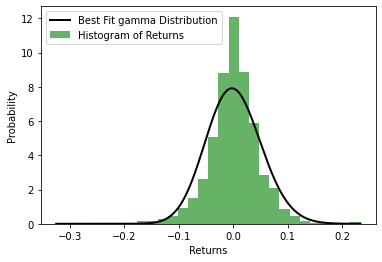

Best distribution: gamma
Best parameters: (152.7577668051336, -0.623045862954352, 0.004089840124215578)
Kolmogorov-Smirnov test p-value: 6.706915020957295e-07
Kolmogorov-Smirnov test rejects the null hypothesis.
Mann-Whitney U test p-value: 0.14297237445137828
Mann-Whitney U test does not reject the null hypothesis.


In [26]:
best_distribution, best_params = find_best_distribution(returns, distributions)

plot_distribution(returns, best_distribution, best_params)

ks_test_result, mw_test_result = perform_goodness_of_fit_tests(returns, best_distribution, best_params)

print(f"Best distribution: {best_distribution}")
print(f"Best parameters: {best_params}")

alpha = 0.01

print(f"Kolmogorov-Smirnov test p-value: {ks_test_result.pvalue}")
if ks_test_result.pvalue < alpha:
    print("Kolmogorov-Smirnov test rejects the null hypothesis.")
else:
    print("Kolmogorov-Smirnov test does not reject the null hypothesis.")

print(f"Mann-Whitney U test p-value: {mw_test_result.pvalue}")
if mw_test_result.pvalue < alpha:
    print("Mann-Whitney U test rejects the null hypothesis.")
else:
    print("Mann-Whitney U test does not reject the null hypothesis.")

In [28]:
x = np.linspace(min(returns), max(returns), 1000)
pdf = getattr(stats, best_distribution)(*best_params).pdf(x)

1788.3349638229338

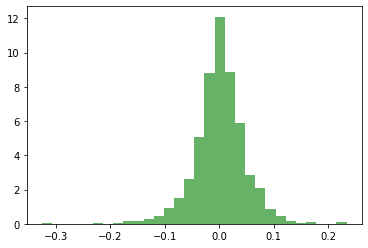

In [34]:
y =plt.hist(returns, bins=30, density=True, alpha=0.6, color='g', label='Histogram of Returns')

In [36]:
y[0]

array([ 0.0537584 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.0537584 ,  0.        ,  0.0537584 ,  0.1612752 ,  0.1612752 ,
        0.268792  ,  0.4300672 ,  0.91389279,  1.50523518,  2.63416157,
        5.05328954,  8.8163775 , 12.09563986,  8.8701359 ,  5.91342393,
        2.84919517,  2.09657758,  0.86013439,  0.48382559,  0.1612752 ,
        0.0537584 ,  0.1075168 ,  0.        ,  0.        ,  0.1075168 ])

In [37]:
y[1]

array([-0.32486075, -0.30624038, -0.28762002, -0.26899965, -0.25037929,
       -0.23175892, -0.21313856, -0.19451819, -0.17589783, -0.15727746,
       -0.1386571 , -0.12003674, -0.10141637, -0.08279601, -0.06417564,
       -0.04555528, -0.02693491, -0.00831455,  0.01030582,  0.02892618,
        0.04754655,  0.06616691,  0.08478728,  0.10340764,  0.12202801,
        0.14064837,  0.15926874,  0.1778891 ,  0.19650946,  0.21512983,
        0.23375019])

In [38]:
returns

array([-1.28467033e-02,  2.23481201e-03, -3.75826007e-02, -8.63059925e-02,
        1.12480553e-02, -7.06834679e-02,  8.44174903e-02,  8.41791842e-03,
        5.66702185e-03,  1.00364908e-02, -9.92347732e-03,  1.63366155e-02,
        1.11169784e-04, -1.95886602e-02, -2.07610005e-02,  1.01221901e-03,
        1.83875040e-02,  3.54113035e-03, -3.70738197e-02,  2.43284161e-03,
        2.70618510e-02,  3.93083834e-02,  1.49552778e-02,  9.77608903e-03,
        3.24742275e-02, -1.42533844e-02, -6.18642806e-03, -2.77656757e-03,
       -3.26750817e-02,  7.68584634e-03,  2.62330330e-02,  3.14229012e-03,
       -2.88324645e-02,  5.76256395e-02,  5.86970398e-02, -1.18335949e-02,
        7.37902892e-03, -1.53548249e-02, -3.34207812e-02,  2.74650730e-02,
       -3.84546168e-02, -2.83739357e-03, -1.20580448e-02,  1.03258607e-02,
        2.60763310e-02, -3.50174936e-02,  1.26088063e-02,  3.69742384e-02,
        3.46722882e-02,  8.99528816e-02, -4.64667484e-02,  4.29290995e-02,
       -2.22127492e-02,  

/Users/aleksandr/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


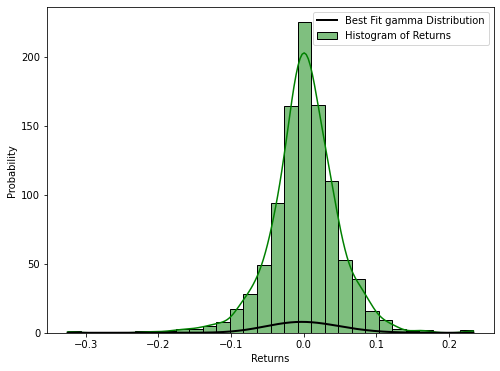

In [40]:
def plot_distribution_with_sns(returns, best_distribution, best_params, num_bins=30):
    plt.figure(figsize=(8, 6))

    # Calculate the histogram with specified number of bins
    counts, bin_edges = np.histogram(returns, bins=num_bins, density=True)

    # Plot the histogram using seaborn
    sns.histplot(returns, bins=bin_edges, kde=True, color='g', label='Histogram of Returns')

    x = np.linspace(min(returns), max(returns), 1000)
    pdf = getattr(stats, best_distribution)(*best_params).pdf(x)

    # Plot the best-fit distribution
    sns.lineplot(x, pdf, color='k', linewidth=2, label=f'Best Fit {best_distribution} Distribution')

    plt.xlabel('Returns')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

# Example usage:
plot_distribution_with_sns(returns, best_distribution, best_params)